This notebook contains code for model training on CelebA dataset. Please refer to Data_prepration.ipynb notebook to see the preprocessing steps for the dataset.

## Boiler Plate

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from fastai.vision import *
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

## Creating a databunch

In [3]:
path = Path('data/faces/')

In [4]:
## Function to filter validation samples
def validation_func(x):
    return 'validation' in x

In [5]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=30, max_lighting=0.3)

In [8]:
src = (ImageList.from_csv(path, csv_name='labels.csv')
       .split_by_valid_func(validation_func)
       .label_from_df(cols='tags',label_delim=' '))

data = (src.transform(tfms, size=128)
       .databunch(bs=256).normalize(imagenet_stats))

In [9]:
print(data.c,'\n',data.classes)

40 
 ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


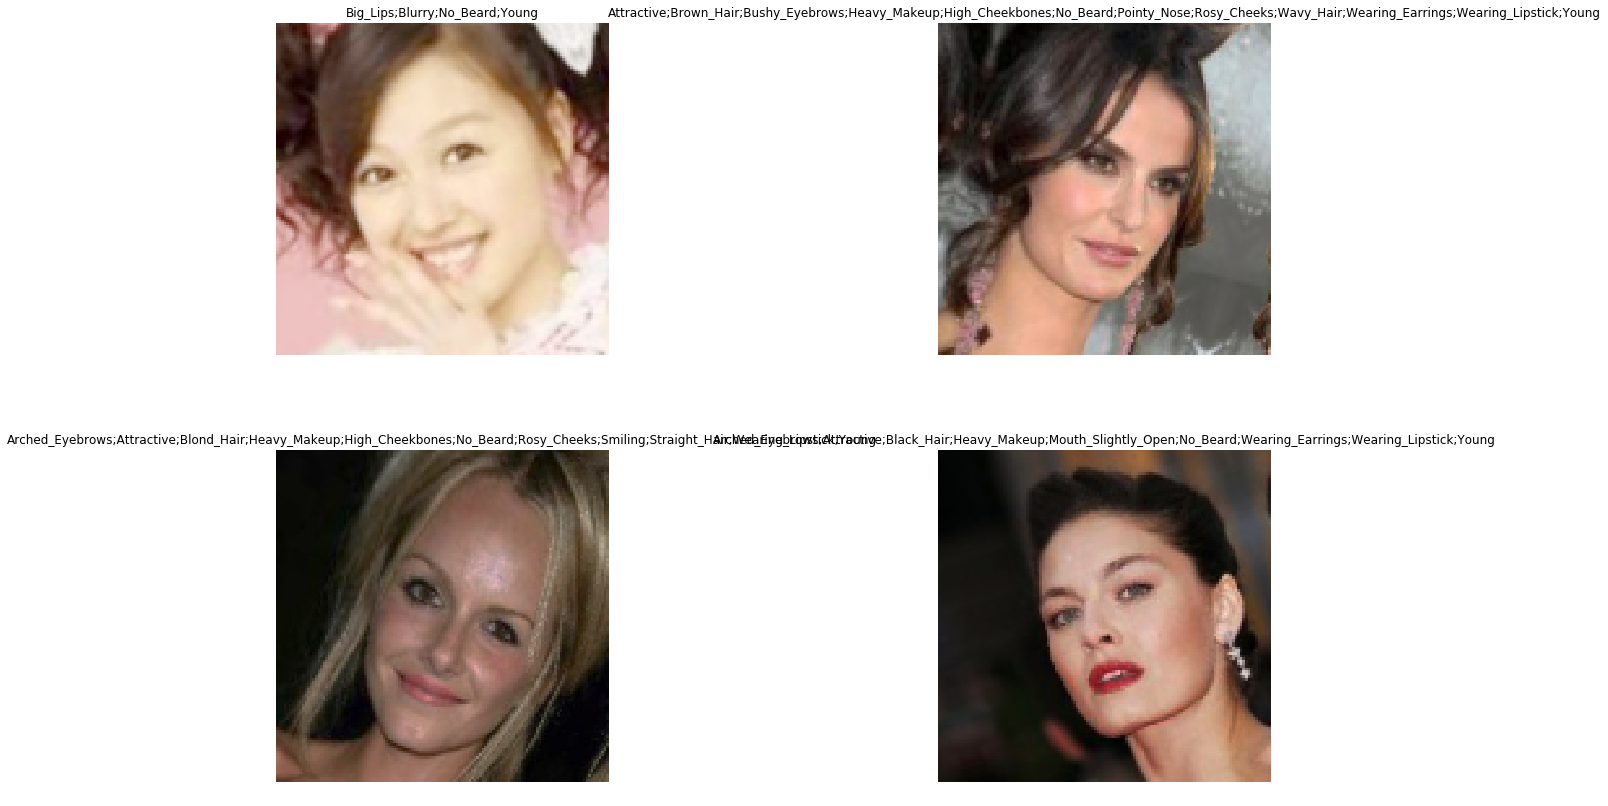

In [10]:
data.show_batch(rows=2, figsize=(20,12))

## Model

We are going to use a resnet50 pretrained model and do transfer learning on CelebA dataset.

In [11]:
arch = models.resnet50

In [12]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
acc_03 = partial(accuracy_thresh, thresh=0.3)
acc_04 = partial(accuracy_thresh, thresh=0.4)
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, acc_03, acc_04, acc_05, f_score])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.2MB/s]


In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


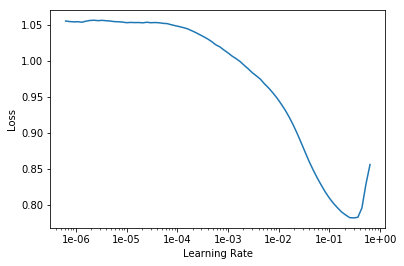

In [14]:
learn.recorder.plot()

In [15]:
# 1e-2 looks like a safe choice
lr = 1e-2

In [16]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.224580,0.213087,0.865042,0.891027,0.901940,0.904311,0.829202,13:51


In [17]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.224883,0.216155,0.868732,0.891317,0.900612,0.902737,0.824796,13:50
1,0.218348,0.209720,0.867462,0.891390,0.902307,0.905714,0.832087,13:50
2,0.212062,0.204255,0.870656,0.894980,0.905298,0.907885,0.836548,13:50
3,0.209216,0.203001,0.871998,0.896011,0.906166,0.908430,0.837684,13:50


In [18]:
learn.save('ff_stage-1-rn50')

Tuning the whole model

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


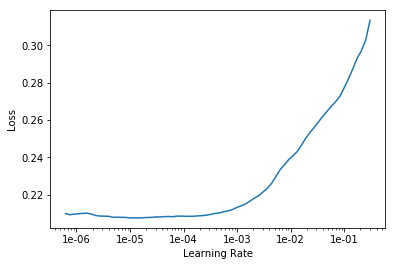

In [20]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.load("ff_stage-1-rn50")
learn.fit_one_cycle(2, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.206337,0.203349,0.872819,0.895752,0.905786,0.908817,0.838093,18:32
1,0.197556,0.193868,0.880354,0.901795,0.910355,0.912669,0.845759,18:33


In [25]:
learn.save('ff_stage-2-rn50')

## Further Training

In [7]:
data = (src.transform(tfms, size=256)
       .databunch(bs=64).normalize(imagenet_stats))

In [8]:
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.5)
learn = create_cnn(data, models.resnet50, pretrained=False,metrics=[acc_05, f_score])
learn.load("ff_stage-2-rn50")

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (158149 items)
[MultiCategory Arched_Eyebrows;Attractive;Brown_Hair;Heavy_Makeup;High_Cheekbones;Mouth_Slightly_Open;No_Beard;Pointy_Nose;Smiling;Straight_Hair;Wearing_Earrings;Wearing_Lipstick;Young, MultiCategory Bags_Under_Eyes;Big_Nose;Brown_Hair;High_Cheekbones;Mouth_Slightly_Open;No_Beard;Smiling;Young, MultiCategory Arched_Eyebrows;Attractive;Big_Lips;Heavy_Makeup;Narrow_Eyes;No_Beard;Pointy_Nose;Wearing_Lipstick;Young, MultiCategory Arched_Eyebrows;Attractive;Big_Lips;Brown_Hair;Heavy_Makeup;Mouth_Slightly_Open;No_Beard;Wavy_Hair;Wearing_Earrings;Wearing_Lipstick;Young, MultiCategory 5_o_Clock_Shadow;Attractive;Bags_Under_Eyes;Big_Lips;Big_Nose;Black_Hair;Bushy_Eyebrows;Male;No_Beard;Pointy_Nose;Straight_Hair;Young]...
Path: ../data/celeba/faces
x: ImageItemList (158149 items)
[Image (3, 186, 186), Image (3, 210, 200), Image (3, 218, 200), Image (3, 175, 175), Image (3, 195, 195)]...
Path: ../data/celeba/faces;

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [13]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(1, slice(lr))

In [ ]:
learn.save('ff_stage-1-256-rn50')

## Visualize

In [9]:
learn = create_cnn(data, models.resnet50, pretrained=False)
learn.load("ff_stage-1-256-rn50")

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (158149 items)
[MultiCategory Arched_Eyebrows;Attractive;Brown_Hair;Heavy_Makeup;High_Cheekbones;Mouth_Slightly_Open;No_Beard;Pointy_Nose;Smiling;Straight_Hair;Wearing_Earrings;Wearing_Lipstick;Young, MultiCategory Bags_Under_Eyes;Big_Nose;Brown_Hair;High_Cheekbones;Mouth_Slightly_Open;No_Beard;Smiling;Young, MultiCategory Arched_Eyebrows;Attractive;Big_Lips;Heavy_Makeup;Narrow_Eyes;No_Beard;Pointy_Nose;Wearing_Lipstick;Young, MultiCategory Arched_Eyebrows;Attractive;Big_Lips;Brown_Hair;Heavy_Makeup;Mouth_Slightly_Open;No_Beard;Wavy_Hair;Wearing_Earrings;Wearing_Lipstick;Young, MultiCategory 5_o_Clock_Shadow;Attractive;Bags_Under_Eyes;Big_Lips;Big_Nose;Black_Hair;Bushy_Eyebrows;Male;No_Beard;Pointy_Nose;Straight_Hair;Young]...
Path: ../data/celeba/faces
x: ImageItemList (158149 items)
[Image (3, 186, 186), Image (3, 210, 200), Image (3, 218, 200), Image (3, 175, 175), Image (3, 195, 195)]...
Path: ../data/celeba/faces;

In [11]:
m = learn.model.eval();

MultiCategory 5_o_Clock_Shadow;Attractive;Big_Lips;Black_Hair;Bushy_Eyebrows;Male;Pointy_Nose;Young

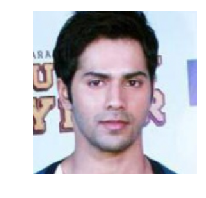

In [12]:
idx=5
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [13]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [14]:
from fastai.callbacks.hooks import *

In [15]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            #preds[0,str(data.valid_ds.y[idx])].backward()
    return hook_a,hook_g

In [16]:
hook_a,hook_g = hooked_backward()

In [17]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 8, 8])

In [18]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([8, 8])

In [19]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear', cmap='magma');

In [21]:
avg_acts

tensor([[0.1239, 0.1161, 0.1969, 0.2996, 0.3264, 0.2652, 0.1210, 0.1589],
        [0.0817, 0.1681, 0.3690, 0.5230, 0.5322, 0.4638, 0.1999, 0.1080],
        [0.1083, 0.2481, 0.5596, 0.6512, 0.6784, 0.6254, 0.3916, 0.1176],
        [0.1183, 0.2719, 0.6762, 0.8231, 0.8321, 0.8809, 0.5946, 0.1239],
        [0.1222, 0.2333, 0.6954, 0.9110, 0.8631, 0.9080, 0.6098, 0.1485],
        [0.1136, 0.2710, 0.6635, 0.8958, 0.9546, 0.8823, 0.5675, 0.1790],
        [0.1248, 0.2195, 0.5213, 0.8167, 0.9258, 0.7355, 0.3567, 0.1693],
        [0.2176, 0.3051, 0.4018, 0.4885, 0.5503, 0.5214, 0.3017, 0.2310]])

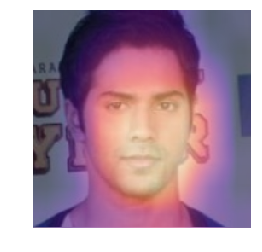

In [20]:
show_heatmap(avg_acts)

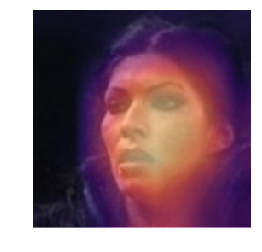

In [43]:
idx=700
x,y = data.valid_ds[idx]
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

hook_a,hook_g = hooked_backward()
acts  = hook_a.stored[0].cpu()
avg_acts = acts.mean(0)
show_heatmap(avg_acts)

In [44]:
avg_acts

tensor([[0.1274, 0.1251, 0.1354, 0.1618, 0.1948, 0.1880, 0.1584, 0.1886],
        [0.0883, 0.0876, 0.1467, 0.3041, 0.3666, 0.3937, 0.2932, 0.1442],
        [0.0856, 0.0972, 0.2797, 0.5750, 0.6964, 0.6726, 0.5347, 0.1960],
        [0.0882, 0.0994, 0.4734, 0.7043, 0.8413, 0.7880, 0.6480, 0.2959],
        [0.0984, 0.1050, 0.5097, 0.7801, 0.8442, 0.8399, 0.6522, 0.3532],
        [0.0936, 0.1161, 0.4971, 0.8241, 0.8975, 0.7498, 0.6325, 0.3602],
        [0.0872, 0.1047, 0.3041, 0.5935, 0.6807, 0.5945, 0.4522, 0.2605],
        [0.1433, 0.1681, 0.2267, 0.4147, 0.5418, 0.5005, 0.3741, 0.2986]])